# SPA against RSA on XMEGA (8-bit implementation)

Supported setups:

SCOPES:

* OPENADC

PLATFORMS:

* CWLITEXMEGA or CW303

Note this *only* works with an XMEGA target. This tutorial does not work with any other platforms. This is because the RSA implementation in use is `avr-crypto-lib`, which is has AVR assembly code to accelerate certain routines. A later tutorial will demonstrate a similar (but not *exactly* the same) attack on MBED-TLS RSA implementation.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'AVRCRYPTOLIB'

## Firmware

Like before, we'll need to setup our `PLATFORM`, then build the firmware if you prefer to "cook your own". Note that a provided .hex file can be used if you don't have the avr-gcc compiler installed.

In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../../hardware/victims/firmware/simpleserial-rsa
make PLATFORM=$1 CRYPTO_TARGET=$2

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-rsa-CWLITEXMEGA.hex
rm -f -- simpleserial-rsa-CWLITEXMEGA.eep
rm -f -- simpleserial-rsa-CWLITEXMEGA.cof
rm -f -- simpleserial-rsa-CWLITEXMEGA.elf
rm -f -- simpleserial-rsa-CWLITEXMEGA.map
rm -f -- simpleserial-rsa-CWLITEXMEGA.sym
rm -f -- simpleserial-rsa-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-rsa.s simpleserial-rsa-xmega.s simpleserial-rsa-arm.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s rsa_basic.s bigint.s
rm -f -- simpleserial-rsa.d simpleserial-rsa-xmega.d simpleserial-rsa-arm.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d rsa_basic.d bigint.d
rm -f -- simpleserial-rsa.i simpleserial-rsa-xmega.i simpleserial-rsa-arm.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i rsa_basic.i bigint.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundati

simpleserial-rsa-xmega.c: In function ‘get_pt’:
simpleserial-rsa-xmega.c:217:19: warning: initialization from incompatible pointer type [-Wincompatible-pointer-types]
 #define ENCRYPTED encrypted_x
                   ^
simpleserial-rsa-xmega.c:314:25: note: in expansion of macro ‘ENCRYPTED’
     const bigint_t* a = ENCRYPTED;
                         ^


## Setup

Setup is the same as usual. Note you don't need to rebuild the RSA implementation if you don't have the AVR compiler available. Check the firmware directory to see the filename for the XMEGA target.

In [3]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
fw_path = '../../../hardware/victims/firmware/simpleserial-rsa/simpleserial-rsa-CWLITEXMEGA.hex'

In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 12207 bytes


## Communicating With Target and Testing

The target is different than normal. We don't use the key commands, instead whatever is sent as the 'text' becomes the key in use. Due to the limited capture length, we need to capture a smaller than normal RSA key. While we might normally have a 512/1024/2048 bit key, we are going to capture only part of it.

Doing so means sending a message with leading 0's, which are not processed. By only using the lower 16 bits of our message, we'll effectively process a 16-bit key.

In [6]:
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 24000

To compare some different keys, we can perform two captures. You should see for example an obvious difference in the power traces below:

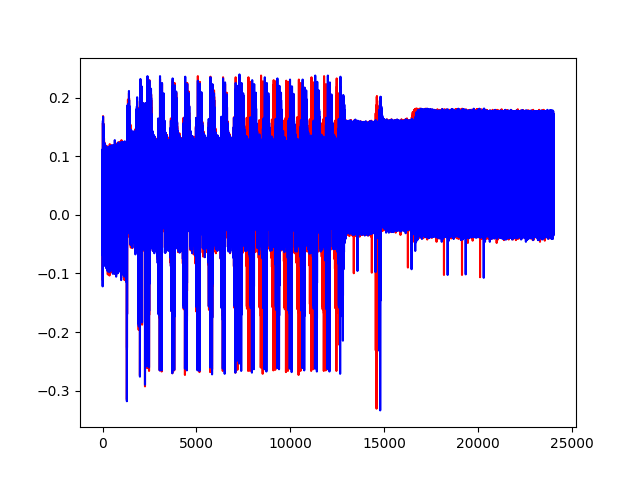

In [8]:
%matplotlib ipympl
import matplotlib.pylab as plt

def capture_RSA_trace(scope, target, text):
    scope.arm()
    target.simpleserial_write('p', text)
    ret = scope.capture()
    if ret:
        return None
    if target.simpleserial_wait_ack() is None:
        print('Ack Failed!!!')
        return None
    return scope.get_last_trace()

text = bytearray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0x80, 0x00])
trace = capture_RSA_trace(scope, target, text)
plt.plot(trace, 'r')
text = bytearray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0x81, 0x00])
trace = capture_RSA_trace(scope, target, text)
plt.plot(trace, 'b')

## Breaking RSA
Now that we have such a target we can get power traces from, how to break RSA? The easiest way is actually with a "single-trace" attack. Let's capture a single RSA trace here:

In [9]:
key = bytearray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0x8A, 0xB0])
trace = capture_RSA_trace(scope, target, key)

You can refer to the original RSA code. But our objective is to compare iterations through the loop - an easy way to do this might be to use some "reference" part of the waveform and sweep it through. Basically, we need to compare two sections in the waveform and see how closely they match at that point in time. Take a look at this original power trace:

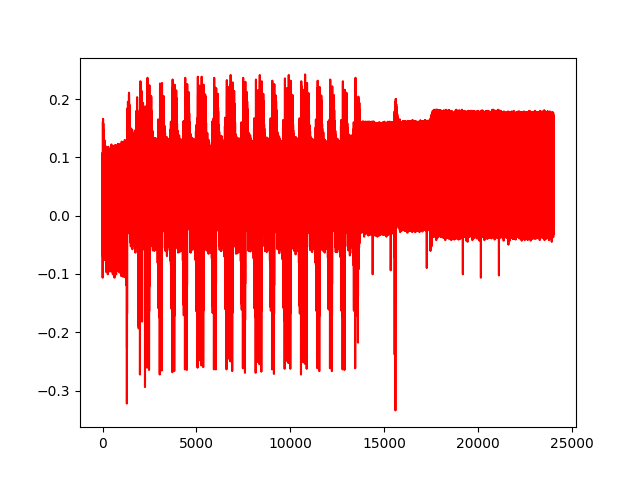

In [10]:
%matplotlib ipympl
import matplotlib.pylab as plt
plt.plot(trace, 'r')

We will select as a "reference" some small section. For example take a look at some points here, does this maybe look unique?

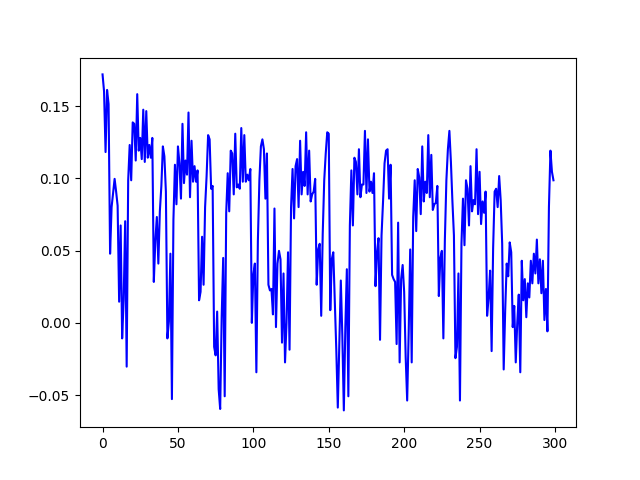

In [11]:
%matplotlib ipympl
import matplotlib.pylab as plt
ref_trace = trace[2600:2900]
plt.plot(ref_trace, 'b')

As you slide the "offset" along, you'll see the resulting pattern be slid along as well. The SAD is calculated and printed.

**NB**: An artifact of Jupyter is that once you run this cell, the `%matplotlib notebook` magic may no longer work. If you want to get interactive graphs again, you'll need to restart the kernel & not run this cell. Restarting the kernel will require you to capture data again. You can easily do the remained of the tutorial without the interactive graphs (meaning it's not needed to restart the kernel after this cell).

In [13]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

@widgets.interact(offset=(0, len(trace)))
def plotsad(offset=2600):
    plt.plot(trace, 'r')
    plt.plot(range(offset, offset+len(ref_trace)), ref_trace, 'b', alpha=0.6)
    plt.figure()
    diff = ref_trace-trace[offset:(offset+len(ref_trace))]
    plt.plot(range(offset, offset+len(ref_trace)), diff, 'g', alpha=0.6)
    print(np.sum(abs(diff)))
    

interactive(children=(IntSlider(value=2600, description='offset', max=24000), Output()), _dom_classes=('widget…

Text(0.5, 0, 'Offset')

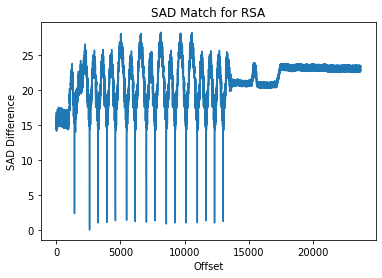

In [15]:
import numpy as np
start = 2600
rsa_one = trace[start:(start+len(ref_trace))]      
diffs = []
for i in range(0, len(trace)-len(rsa_one)):
    diff = rsa_one - trace[i:(i+len(rsa_one))]    
    diffs.append(np.sum(abs(diff)))
    
plt.figure()
plt.plot(diffs)
plt.title('SAD Match for RSA')
plt.ylabel('SAD Difference')
plt.xlabel('Offset')

Find a good threshold based on what seems to result in a "SAD match". Use that number in the following block for the np.where (here it's set to 10.0):

In [ ]:
import numpy as np

times = np.where(np.array(diffs) < 5.0)[0]
print(times)
deltalist = []
for i in range(0, len(times)-1):
    delta = times[i+1] - times[i]
    deltalist.append(delta)

In [ ]:
print(deltalist)
print(len(deltalist))

And we can then plot the time deltas:

In [ ]:
%matplotlib ipympl
plt.plot(deltalist, range(0, len(deltalist)), linestyle='None', marker='.', color='r',)
plt.grid(True)
plt.title('A Learned Comparison of RSA Execution Time')
plt.ylabel('Processing Bit Number')
plt.xlabel('Time Delta (based on SAD Match)')

Putting it all together - let's try and use a good difference in the processing time to figure out if a bit is a 0 or 1. In my example the above graph seems to have a nice split around 1400 cycle time delta. Yours might change with different compilers!

In [ ]:
import numpy as np
key = ""
times = np.where(np.array(diffs) < 5.0)[0]
for i in range(0, len(times)-1):
    delta = times[i+1] - times[i]
    # print(delta)
    if delta > 700:
        key += "1"
    else:
        key += "0"
key += "0"
print("{:04X}".format(int(key, 2)))

Hopefully that recovered the encryption key you set earlier! The last caveat is the *last bit* isn't recovered. Can you figure out a way to recover it? Why isn't it recovered?

## Plotting Bandwidth-Limited Data

Two additional notes that you might have heard about before:
 
 * RSA attacks often require a lot less bandwidth. 
 * Can we just "read off" the 1 vs 0?
 
In this example, we didn't see the obvious '1 vs 0'. But some simple filtering can help us recover it. Experiment with the bandwidth (set by the `bw` variable) of this low-pass filter.

In [ ]:
from scipy.signal import butter, lfilter

bw = 0.00066

b, a = butter(3, bw, btype='low')

y = lfilter(b, a, trace)

print(7.37E6 * 0.001)

plt.plot(y)

Can you adjust the red & black lines such that peaks for '1' are above the black line, and peaks for '0' are above the red & black line? Once you get these good values, we can build *another* way of recovering the RSA private key.

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

#You may need to adjust the ranges!!!
@widgets.interact(low=(0.0, 0.15, 0.002),
                  high=(0.0,0.15, 0.002))
def plotlimits(low=0.085, high=0.095):
    plt.plot(y, 'b')
    plt.plot([0, len(y)], [low, low], 'r')
    plt.plot([0, len(y)], [high, high], 'k')
    
    print("Low: {:f}, High: {:f}".format(low, high))


In fact, we can use some simple Python magic to avoid needing to do the dual threshold. We notice the real goal is just finding the local maximums, and check if it's above/below that maximum threshold. While the good news is later versions of scipy have this built in for us! So we can check if the local maxima functions make sense:

In [ ]:
import numpy as np
from scipy.signal import argrelextrema

# for local maxima - see this
local_max = argrelextrema(y, np.greater)
print(local_max)
#Note we really need to index to get the actual list
print(local_max[0])

And with a bit of finagling, we can convert that into a key. You'll need to modify the threshold that is hard-coded in this example based on what you found made sense earlier:

In [ ]:
l = [y[i] for i in local_max[0]]

In [ ]:
print(l)

In [ ]:
print(np.average(l))

In [ ]:
key_filt = ""
for m in local_max[0]:

    if y[m] > 0.081:
        key_filt += "1"
    else:
        key_filt += "0"
key_filt += "0"
print("%04X"%int(key_filt, 2))

Yipee! Hopefully this worked out and recovered the same key as above. How low of a bandwidth can you work with and still recover the key?

Remember that the original power trace had perfect synchronization. So in real life you might need a higher bandwidth, but you should see compared to a DPA attack that it's still a lot lower.

## Conclusion

This tutorial has demonstrated the use of the power side-channel for performing RSA 8-bit attacks. We attacked it both using a SAD match to find the interesting points, and by performing a bandwidth-specific filter to make it more obvious when sections are 1 vs 0.

In [ ]:
scope.dis()
target.dis()

## Tests

In [ ]:
assert int(key_filt, 2) == 0x8AB0, "Failed to break key with filter, adjust maximum"

In [ ]:
assert int(key, 2) == 0x8AB0, "Failed to break key with SAD Match"